# <ins>Movie Recommendation System</ins>

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# loading csv's into dataframes
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')
movies = pd.read_csv('movies.csv')
links = pd.read_csv('links.csv')

## Content of Files

**ratings:** 
- Each row represents one rating of one movie by one user
- Ratings are made on a 5-star scale, with half-star increments 

**tags:** 
- Each row represents one tag applied to one movie by one user
- Tags are user-generated metadata about movies. Each tag is typically a single word or short phrase. The meaning, value, and purpose of a particular tag is determined by each user

**movies:** 
- Each row represents one movie
- Movie titles are entered manually or imported from https://www.themoviedb.org/, and include the year of release in parentheses. Errors and inconsistencies may exist in these titles

**links:** 
- Identifiers that can be used to link to other sources of movie data; each row represents one movie


In [50]:
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [51]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
# merging movie and rating dataframes 
df = ratings.merge(movies,on='movieId', how='left')

In [8]:
# dropping timestamp column
df.drop(columns = 'timestamp',inplace=True)

# <ins>EDA</ins>

In [10]:
df.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


## Genres

In [52]:
# creating dictionary of genres 
genres = []
for row in df['genres']: 
    genres.extend(row.split('|'))
genre_dict = {}
for genre in genres:
    if genre in genre_dict: 
        genre_dict[genre] += 1
    else:
        genre_dict[genre] = 1
# creating df 
genres = {'Genre': list(genre_dict.keys()), 'Count': list(genre_dict.values())}
genre_df = pd.DataFrame(genres)
sorted_genres = genre_df.sort_values(by='Count',ascending=False)

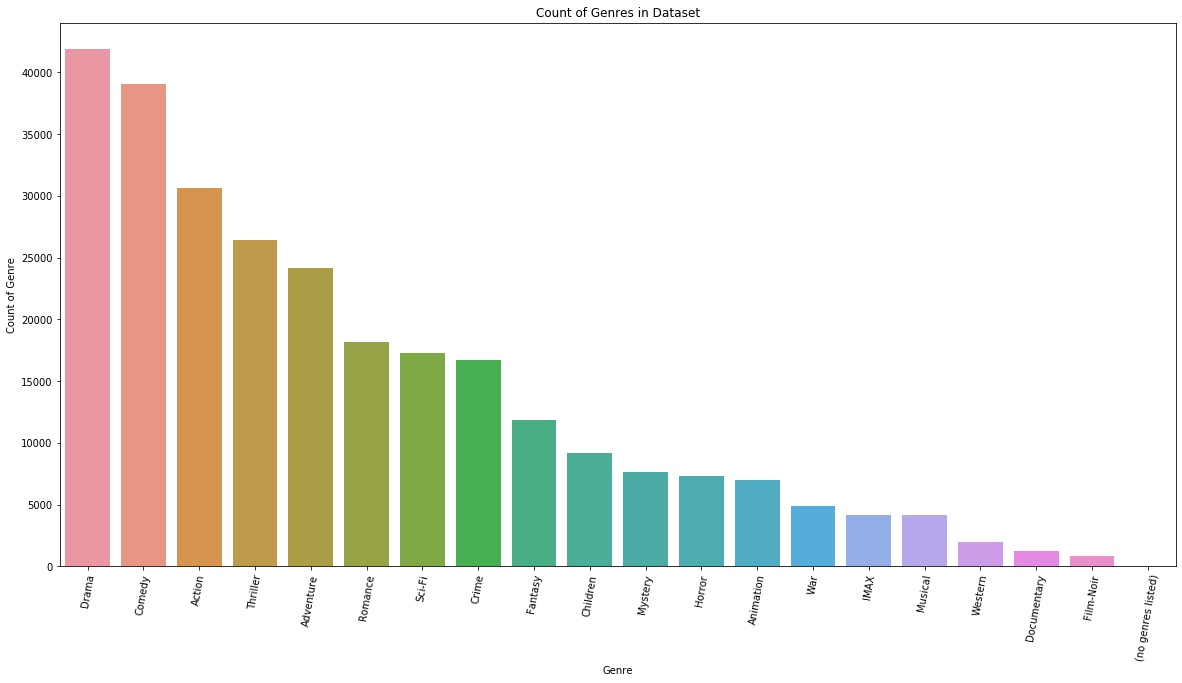

In [12]:
# barplot of genres
x = sorted_genres['Genre']
y = sorted_genres['Count']

fig, ax = plt.subplots(figsize=(20,10))
ax.bar(x,y)
sns.barplot(x,y)

ax.set_xticklabels(x,rotation=80)
ax.set_ylabel("Count of Genre")
ax.set_title("Count of Genres in Dataset");


## Ratings

In [13]:
ratings_counts = df['rating'].value_counts().sort_index(ascending = False)

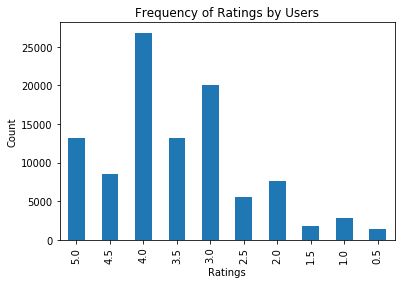

In [15]:
fig, ax = plt.subplots()
ax = ratings_counts.plot(kind="bar")
ax.set_ylabel('Count')
ax.set_xlabel('Ratings')
ax.set_title('Frequency of Ratings by Users');

In [16]:
# average ratings per movie 
df.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Karlson Returns (1970)                           5.0
Winter in Prostokvashino (1984)                  5.0
My Love (2006)                                   5.0
Sorority House Massacre II (1990)                5.0
Winnie the Pooh and the Day of Concern (1972)    5.0
Name: rating, dtype: float64

In [17]:
# looking at rating counts for each movie since the above is being skewed by movies with only 1 or a few ratings by users
df.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
Name: rating, dtype: int64

In [18]:
# creating a df with title, rating, and rating counts for each movie
ratings_mean_count = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings_mean_count.head()

,rating,rating_counts
title,,
'71 (2014),4.0,1
'Hellboy': The Seeds of Creation (2004),4.0,1
'Round Midnight (1986),3.5,2
'Salem's Lot (2004),5.0,1
'Til There Was You (1997),4.0,2


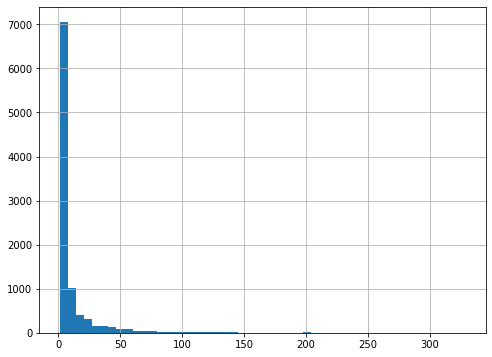

In [19]:
# graph showing that most movies have under 50 ratings
plt.figure(figsize=(8,6))
ratings_mean_count['rating_counts'].hist(bins=50)

In [20]:
rating_over50 = ratings_mean_count[ratings_mean_count['rating_counts']>50]
rating_over50.sort_values(by='rating',ascending=False)

,rating,rating_counts
title,,
"Shawshank Redemption, The (1994)",4.429022,317
"Godfather, The (1972)",4.289062,192
Fight Club (1999),4.272936,218
Cool Hand Luke (1967),4.271930,57
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964),4.268041,97
...,...,...
Johnny Mnemonic (1995),2.679245,53
Judge Dredd (1995),2.669355,62
City Slickers II: The Legend of Curly's Gold (1994),2.645455,55


# <ins>Simple Recommendation System</ins>

In [21]:
# matrix of movie titles and their user ratings 
user_movie_rating = df.pivot_table(index='userId', columns='title', values='rating')
user_movie_rating.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# looking at Toy Story's correlation with all other movies 
correlations = user_movie_rating.corrwith(user_movie_rating['Toy Story (1995)'])
recommendation = pd.DataFrame(correlations,columns=['Correlation'])
recommendation.dropna(inplace=True)
recommendation = recommendation.join(ratings_mean_count['rating_counts'])
recommendation.head()

/Users/laurencunningham/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/laurencunningham/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,Correlation,rating_counts
title,,
"'burbs, The (1989)",0.240563,17
(500) Days of Summer (2009),0.353833,42
*batteries not included (1987),-0.427425,7
10 Cent Pistol (2015),1.000000,2
10 Cloverfield Lane (2016),-0.285732,14


In [23]:
# sorting movies correlated with Toy Story with at least 100 ratings
recc = recommendation[recommendation['rating_counts']>100].sort_values('Correlation',ascending=False).reset_index()
recc = recc.merge(movies,on='title', how='left')
recc.head(10)

,title,Correlation,rating_counts,movieId,genres
0,Toy Story (1995),1.000000,215,1,Adventure|Animation|Children|Comedy|Fantasy
1,"Incredibles, The (2004)",0.643301,125,8961,Action|Adventure|Animation|Children|Comedy
2,Finding Nemo (2003),0.618701,141,6377,Adventure|Animation|Children|Comedy
3,Aladdin (1992),0.611892,183,588,Adventure|Animation|Children|Comedy|Musical
4,"Monsters, Inc. (2001)",0.490231,132,4886,Adventure|Animation|Children|Comedy|Fantasy
5,Mrs. Doubtfire (1993),0.446261,144,500,Comedy|Drama
6,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",0.438237,120,4973,Comedy|Romance
7,American Pie (1999),0.420117,103,2706,Comedy|Romance
8,Die Hard: With a Vengeance (1995),0.410939,144,165,Action|Crime|Thriller
9,E.T. the Extra-Terrestrial (1982),0.409216,122,1097,Children|Drama|Sci-Fi


Now we can see the movies that are highly correlated with Toy Story, however, this is just a very simple recommender system...next I will use collaborative filtering and content-based filtering to find a better model for my recommendation system!

# <ins>Recommendations with Surprise</ins>

In [24]:
!Pip install scikit-surprise

In [25]:
# dropping timestamp column and converting ratings file to a df
ratings = ratings.drop(columns='timestamp')

In [26]:
# reading in the ratings dataset using surprise
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
reader = Reader()
data = Dataset.load_from_df(ratings, reader)

In [27]:
# checking how many users and items in our dataset 
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  610 

Number of items:  9724


In [28]:
# importing libraries for modeling
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
import numpy as np

In [29]:
# performing gridsearch with SVD
params = {'n_factors': [20, 50, 100],
         'reg_all': [0.02, 0.05, 0.1]}
g_s_svd = GridSearchCV(SVD,param_grid=params,n_jobs=-1)
g_s_svd.fit(data)

In [30]:
# determining best score and params
print(g_s_svd.best_score)
print(g_s_svd.best_params)

{'rmse': 0.8691338110378137, 'mae': 0.6678530974058802}
{'rmse': {'n_factors': 100, 'reg_all': 0.05}, 'mae': {'n_factors': 20, 'reg_all': 0.02}}


In [31]:
# cross validating with KNN basic 
knn_basic = KNNBasic(sim_options={'name':'pearson', 'user_based':True})
cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1)

In [32]:
for i in cv_knn_basic.items():
    print(i)
print('-----------------------')
print(np.mean(cv_knn_basic['test_rmse']))

('test_rmse', array([0.97072278, 0.97535558, 0.9653157 , 0.97766163, 0.97453935]))
('test_mae', array([0.74611695, 0.75499735, 0.748844  , 0.75443441, 0.75164927]))
('fit_time', (0.3637087345123291, 0.35565900802612305, 0.3371398448944092, 0.3429861068725586, 0.33878183364868164))
('test_time', (1.1345820426940918, 1.0894019603729248, 1.072645902633667, 1.06272292137146, 1.0366919040679932))
-----------------------
0.9727190096247978


In [33]:
# cross validating with KNN baseline 
knn_baseline = KNNBaseline(sim_options={'name':'pearson', 'user_based':True})
cv_knn_baseline = cross_validate(knn_baseline,data)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [34]:
for i in cv_knn_baseline.items():
    print(i)

np.mean(cv_knn_baseline['test_rmse'])

('test_rmse', array([0.87794525, 0.87034088, 0.88291885, 0.88533069, 0.87542233]))
('test_mae', array([0.66928479, 0.66533451, 0.67417305, 0.67561933, 0.67083375]))
('fit_time', (0.6225318908691406, 0.6510848999023438, 0.6559879779815674, 0.6389968395233154, 0.6599481105804443))
('test_time', (1.7714581489562988, 1.6236910820007324, 1.7097179889678955, 1.607719898223877, 1.6761579513549805))


0.8783915987692422

The best performing model is SVD with n_factors = 20 and regularization rate of of 0.02. 

I used RMSE to evaluate these models. RMSE is

## Recommendation System - New User

In [53]:
user_24 = ratings[ratings['userId']==24]

In [36]:
# chose user and some of their preferences 
user_rating = [{'userId': 24, 'movieId': 3902, 'rating': '4.5'},
 {'userId': 24, 'movieId': 3904, 'rating': '4.0'},
 {'userId': 24, 'movieId': 4007, 'rating': '4.0'},
 {'userId': 24, 'movieId': 4009, 'rating': '2.5'},
 {'userId': 24, 'movieId': 4011, 'rating': '3.0'}]

In [38]:
new_ratings_df = ratings.append(user_rating,ignore_index=True)
new_data = Dataset.load_from_df(new_ratings_df,reader)

In [42]:
svd_ = SVD(n_factors=20, reg_all=0.02)
svd_.fit(new_data.build_full_trainset())

In [43]:
list_of_movies = []
for m_id in ratings['movieId'].unique():
    list_of_movies.append( (m_id,svd_.predict(1000,m_id)[3]))

In [44]:
ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)

In [46]:
def recommended_movies(user_ratings,movie_title_df,n):
        for idx, rec in enumerate(user_ratings):
            title = movie_title_df.loc[movie_title_df['movieId'] == int(rec[0])]['title']
            print('Recommendation # ', idx+1, ': ', title, '\n')
            n-= 1
            if n == 0:
                break
            
recommended_movies(ranked_movies,movies,5)

Recommendation #  1 :  277    Shawshank Redemption, The (1994)
Name: title, dtype: object 

Recommendation #  2 :  906    Lawrence of Arabia (1962)
Name: title, dtype: object 

Recommendation #  3 :  602    Dr. Strangelove or: How I Learned to Stop Worr...
Name: title, dtype: object 

Recommendation #  4 :  686    Rear Window (1954)
Name: title, dtype: object 

Recommendation #  5 :  841    Streetcar Named Desire, A (1951)
Name: title, dtype: object 

